# Segmentez les clients d'un site e-commerce

This notebook aims at exploring the different dataset provided by Olist. It is the first step in a marketing project of customer segmentation. 

In [1]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Style
font_perso = {'family': 'serif',
              'color':  'k',
              'size': 18,
             }

sns.set_style("darkgrid")

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Data load
customers = pd.read_csv(r'./Data/olist_customers_dataset.csv', sep = ',', low_memory=False)
geoloc = pd.read_csv(r'./Data/olist_geolocation_dataset.csv', sep = ',', low_memory=False)
order_items = pd.read_csv(r'./Data/olist_order_items_dataset.csv', sep = ',', low_memory=False)
order_payments = pd.read_csv(r'./Data/olist_order_payments_dataset.csv', sep = ',', low_memory=False)
order_reviews = pd.read_csv(r'./Data/olist_order_reviews_dataset.csv', sep = ',', low_memory=False)
orders = pd.read_csv(r'./Data/olist_orders_dataset.csv', sep = ',', low_memory=False)
products = pd.read_csv(r'./Data/olist_products_dataset.csv', sep = ',', low_memory=False)
sellers = pd.read_csv(r'./Data/olist_sellers_dataset.csv', sep = ',', low_memory=False)
translation = pd.read_csv(r'./Data/product_category_name_translation.csv', sep = ',', low_memory=False)

df_list = [customers, geoloc, order_items, order_payments, order_reviews, orders, products, sellers, translation]

In [4]:
for df in df_list:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

we might have interesting information in every single dataframe, and their respective weight seem quite light in terms of RAM. So we are going to merge them all.

### Merging

In [5]:
# Merge with the help of the relational_db scheme
orders_clients = pd.merge(customers, orders, on = 'customer_id')
orders_infos = pd.merge(order_payments, order_reviews, on = 'order_id')

orders_full = pd.merge(orders_clients, orders_infos, on = 'order_id')

products_sellers = pd.merge(sellers, order_items, on = 'seller_id')
products_english = pd.merge(products, translation, on = 'product_category_name')

products_full = pd.merge(products_sellers, products_english, on = 'product_id')


db_full = pd.merge(orders_full, products_full, on = 'order_id')


In [6]:
db_full_geo = pd.merge(db_full, geoloc, left_on = 'customer_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = 'left')
db_full_geo.shape

(17659175, 45)

We got an issue when trying to merge the db_full dataframe with the geolocation information as we now have 17 million observations instead of 115 thousand.
Considering we already have zip-code information, we are gonna ignore the geolocation dataframe for now.

In [7]:
db_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    115609 non-null  object 
 1   customer_unique_id             115609 non-null  object 
 2   customer_zip_code_prefix       115609 non-null  int64  
 3   customer_city                  115609 non-null  object 
 4   customer_state                 115609 non-null  object 
 5   order_id                       115609 non-null  object 
 6   order_status                   115609 non-null  object 
 7   order_purchase_timestamp       115609 non-null  object 
 8   order_approved_at              115595 non-null  object 
 9   order_delivered_carrier_date   114414 non-null  object 
 10  order_delivered_customer_date  113209 non-null  object 
 11  order_estimated_delivery_date  115609 non-null  object 
 12  payment_sequential            

### Missing values

<AxesSubplot:>

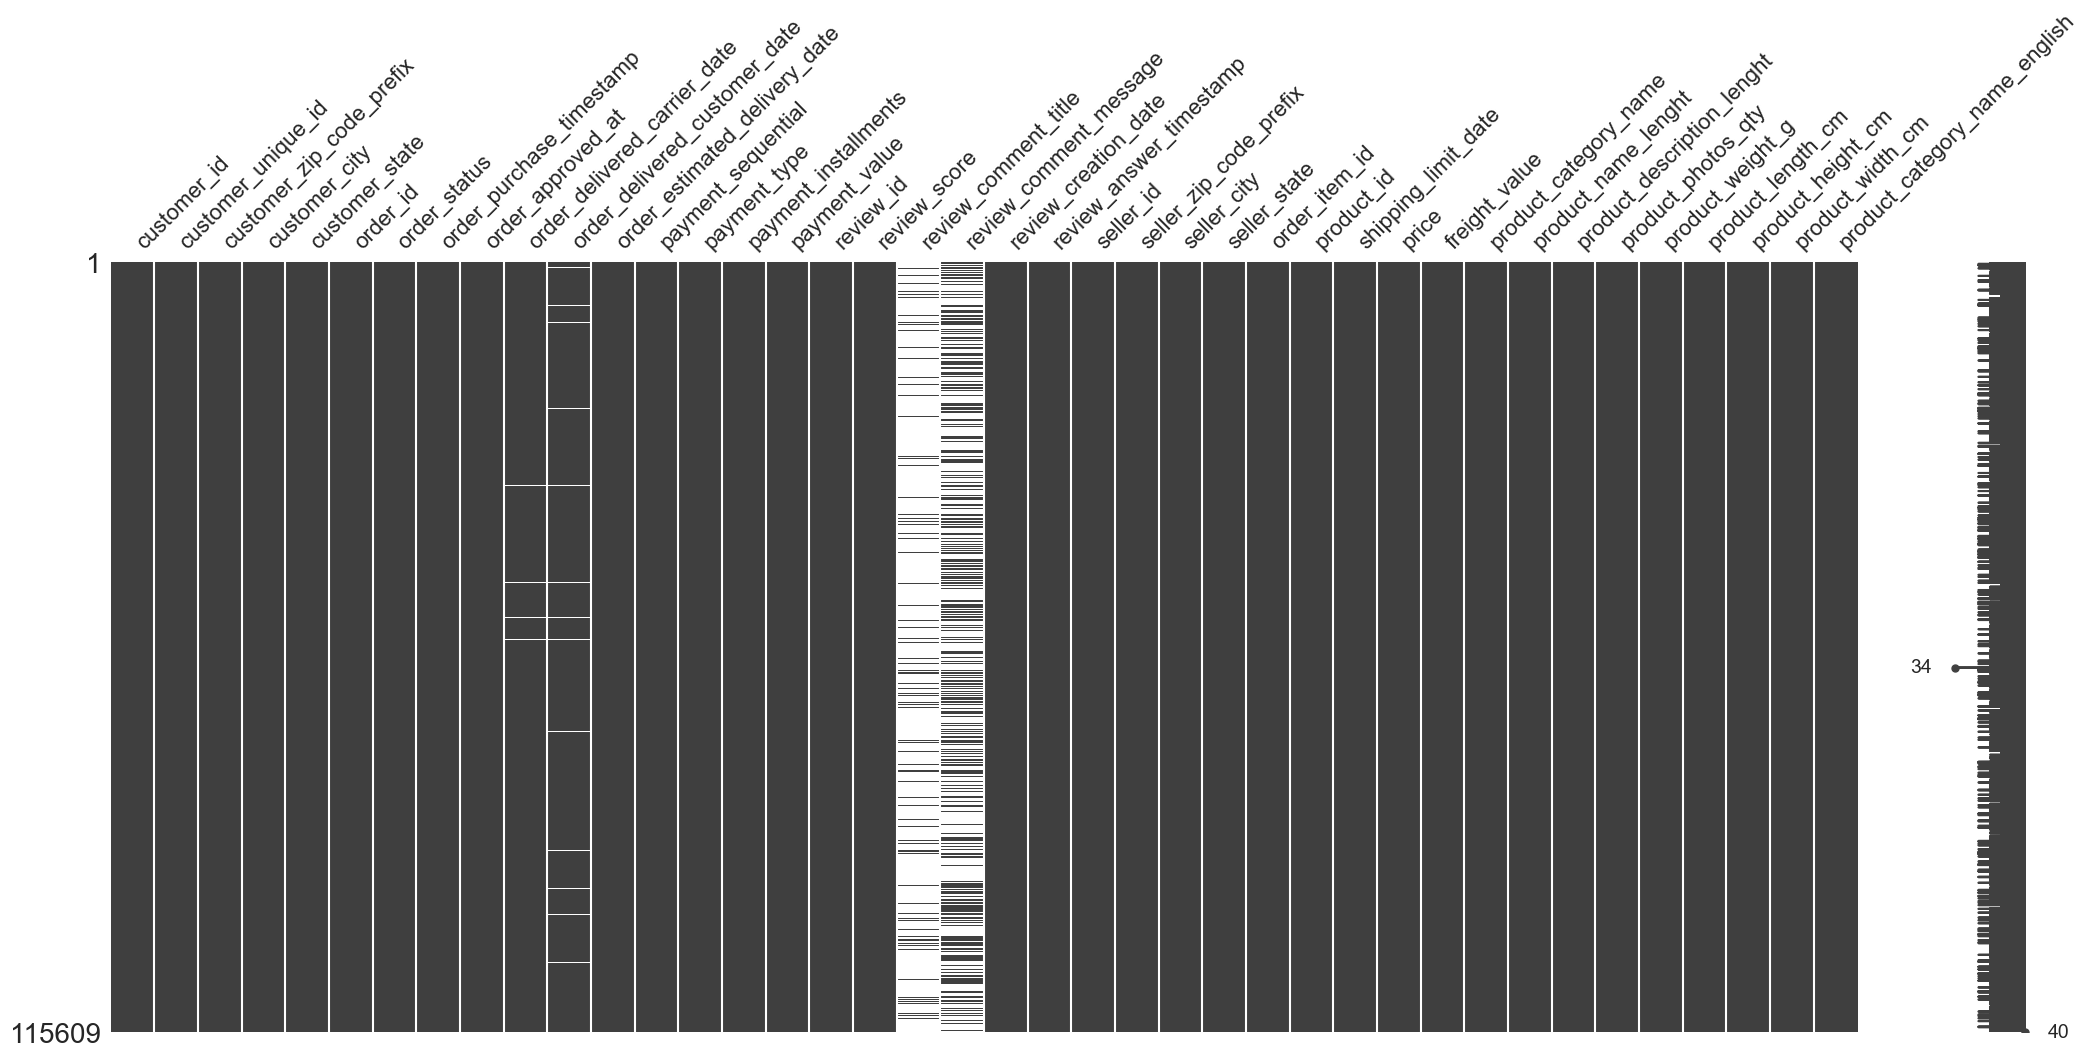

In [8]:
# Missing values check
%matplotlib inline
msno.matrix(db_full)

The dataset looks quite complete with only the review comment variable unsufficiently documented. However, this is not an issue considering the scope of our project.

### EDA

#### Customers

According to the data owner, a new 'customer_id' is created each time an order is made, while 'customer_unique_id' is attributed only once to a given customer, who keeps it when he order new products.

In [9]:
db_full['customer_unique_id'].nunique()

93396

We have 93396 unique clients, for 115609 columns, meaning that only 115609-93396 =  22213 customers have ordered more than once. In view of performing a customer analysis, this is not ideal, but 22K+ observations is still an acceptable number.

#### Customers location

In [ ]:
# Customers location lat-long
customers_geoloc = pd.merge(customers, geoloc, 
                            left_on="customer_zip_code_prefix", 
                            right_on="geolocation_zip_code_prefix",
                            how = "left")
customers_geoloc = customers_geoloc.drop_duplicates("customer_unique_id")
customers_geoloc = customers_geoloc.dropna(subset="geolocation_lat")

# Brazil map of customers
import folium
import folium.plugins

# Brazil center approx. coordinates
brazil_center_lat = -10
brazil_center_lng = -50
brazil_map = folium.Map(location=[brazil_center_lat, brazil_center_lng], zoom_start=4)

# Customers clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(brazil_map)
for lat, lng, in zip(customers_geoloc.geolocation_lat, customers_geoloc.geolocation_lng):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

brazil_map

The vast majority of our customers is along the eastern and south-eastern atlantic coast.

#### Sellers geolocation

In [ ]:
# Sellers location lat-long
sellers_geoloc = pd.merge(sellers, geoloc, 
                            left_on="seller_zip_code_prefix", 
                            right_on="geolocation_zip_code_prefix",
                            how = "left")
sellers_geoloc = sellers_geoloc.drop_duplicates("seller_id")
sellers_geoloc = sellers_geoloc.dropna(subset="geolocation_lat")

# Brazil map of sellers
import folium
import folium.plugins

# Brazil center approx. coordinates
brazil_center_lat = -10
brazil_center_lng = -50
brazil_map = folium.Map(location=[brazil_center_lat, brazil_center_lng], zoom_start=4)

# Sellers clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(brazil_map)
for lat, lng, in zip(sellers_geoloc.geolocation_lat, sellers_geoloc.geolocation_lng):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

brazil_map

Regarding the sellers, we see that almost all entities are in the south of the country, with only 5 of them in the north and west of the country.

In [12]:
#### Delivery delay
db_full[['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']] = db_full[['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].applymap(pd.to_datetime)
db_full[['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 3 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_delivered_carrier_date   114414 non-null  datetime64[ns]
 1   order_delivered_customer_date  113209 non-null  datetime64[ns]
 2   order_estimated_delivery_date  115609 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 3.5 MB


In [13]:
db_full["Late?"] = db_full['order_delivered_customer_date'] > db_full['order_estimated_delivery_date']
db_full["Late?"].sum()

8715

On all orders, only 8715 have been delivered later than the estimated delivery date. Let's see if the delays where big, and if it has something to do with the location of the customer.

In [14]:
# How late was the order?
db_full["How_late?"] = db_full['order_delivered_customer_date'] - db_full['order_estimated_delivery_date']

In [15]:
db_full["How_late?"].describe()

count                          113209
mean     -12 days +14:30:34.043583108
std        10 days 02:14:24.693627420
min               -147 days +23:36:47
25%                -17 days +16:13:21
50%                -13 days +22:21:25
75%                 -7 days +10:48:57
max                 188 days 23:24:07
Name: How_late?, dtype: object

It is very interesting to see that on average, Olist estimates a delivery which is 12 days after the effective delivery. I cannot see a reasonable explanation on why they are so conservative and wrong in giving an estimation.

In [ ]:
# Does the location explain the delays?
late_orders_customers = db_full[['Late?', 'How_late?', 'customer_id', 'customer_unique_id', 'customer_zip_code_prefix']]
                                 
# Customers location lat-long
late_orders_customers_geoloc = pd.merge(late_orders_customers, geoloc, 
                            left_on="customer_zip_code_prefix", 
                            right_on="geolocation_zip_code_prefix",
                            how = "left")

late_orders_customers_geoloc = late_orders_customers_geoloc.drop_duplicates('customer_unique_id')
late_orders_customers_geoloc = late_orders_customers_geoloc[late_orders_customers_geoloc['Late?'] == True]
late_orders_customers_geoloc = late_orders_customers_geoloc.dropna(subset="geolocation_lat")

# Brazil map of customers having recieved at least 1 order late
import folium
import folium.plugins

# Brazil center approx. coordinates
brazil_center_lat = -10
brazil_center_lng = -50
brazil_late_orders_map = folium.Map(location=[brazil_center_lat, brazil_center_lng], zoom_start=4)

# Customers clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(brazil_late_orders_map)
for lat, lng, in zip(late_orders_customers_geoloc.geolocation_lat, late_orders_customers_geoloc.geolocation_lng):
    folium.Marker(location=[lat, lng]).add_to(marker_cluster)

brazil_late_orders_map

With regards to the locations of all customers, it doesn't seem that the north-western customers have encountered more delays then their southern counterparts. At first glance, location does not seem to influence order delays.

#### Price of order and shipping

In [17]:
# Total price paid = payment_value?
db_full[['payment_value', 'price', 'freight_value']].describe(percentiles=[0.10,0.25,0.5,0.75,0.9])

,payment_value,price,freight_value
count,"115,609.00","115,609.00","115,609.00"
mean,172.39,120.62,20.06
std,265.87,182.65,15.84
min,0.00,0.85,0.00
10%,36.45,23.80,8.79
25%,60.87,39.90,13.08
50%,108.05,74.90,16.32
75%,189.48,134.90,21.21
90%,338.53,229.90,34.15
max,"13,664.08","6,735.00",409.68


There are some huge orders that are very rare so we are gonna remove them from the graphical analysis as they can be considered as outliers.

In [18]:
db_full = db_full[~(db_full['price'] > (db_full['price'].mean()+(2.5*db_full['price'].std())))]
db_full = db_full[~(db_full['freight_value'] > (db_full['freight_value'].mean()+(2.5*db_full['freight_value'].std())))]


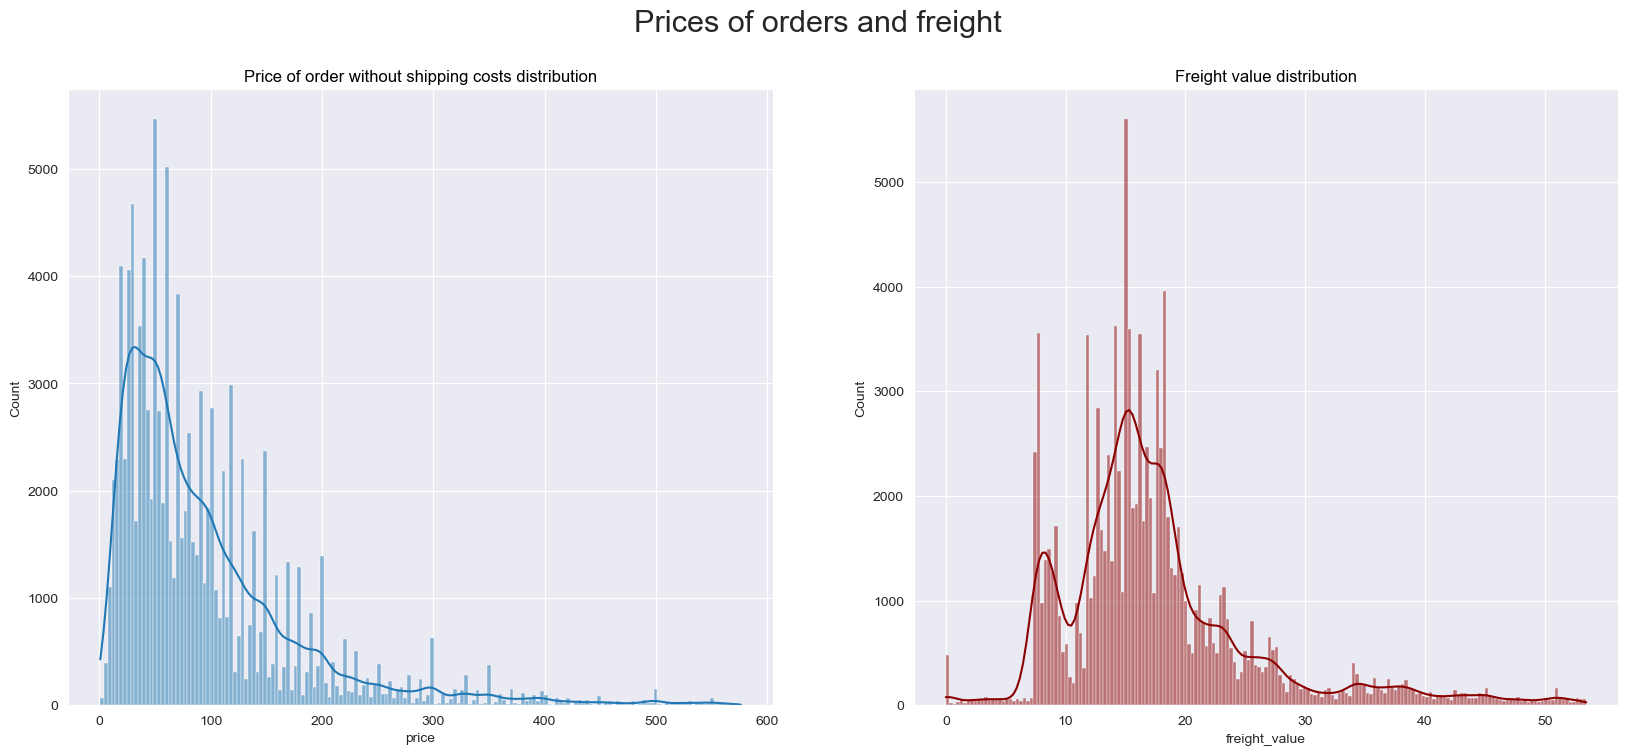

In [19]:
# Energy consumptions and GHG emissions - zoomed-in distributions 
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height

sns.histplot(data=db_full, x='price', kde=True, ax=axes[0], alpha=0.5)
axes[0].set_title("Price of order without shipping costs distribution", color='black')


sns.histplot(data = db_full, x='freight_value', kde=True, ax=axes[1], color="darkred", alpha=0.5)
axes[1].set_title("Freight value distribution", color='black')

plt.suptitle("Prices of orders and freight", fontsize=22)
plt.show()

We see that a lot of order's prices are rounded, when the shipping price seem more regularly distributed.

#### Payment caracteristics

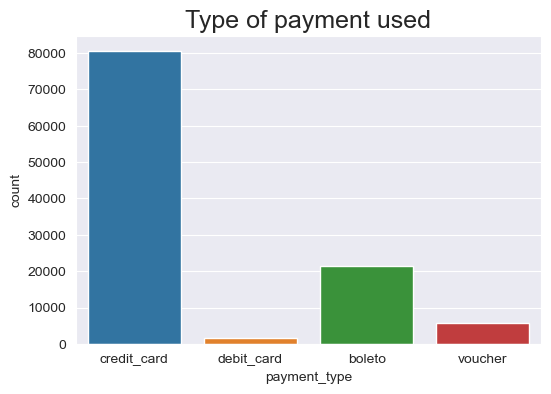

In [20]:
# Payment types
sns.set_style("darkgrid")
fig = plt.figure(figsize=(6,4))
sns.countplot(x ='payment_type', data = db_full)
plt.title("Type of payment used", fontsize=18)
plt.show()

In [21]:
# Sequential payment?
db_full.groupby('payment_sequential').count()['order_id']

payment_sequential
1     105037
2       3099
3        603
4        287
5        163
6        109
7         75
8         53
9         43
10        36
11        31
12        23
13        12
14        10
15         9
16         8
17         8
18         8
19         8
20         5
21         5
22         2
23         1
24         1
25         1
26         1
Name: order_id, dtype: int64

On more than 115000 orders, 110662 have been paid in a single payment.
It's interesting to note that the 'x4 payment' which is the preferred sequential-payment in europe is not really favorised in Brazil when it comes to pay in several takings.

#### Customer satisfaction

In [22]:
db_full['review_score'].describe()

count   109,638.00
mean          4.04
std           1.38
min           1.00
25%           4.00
50%           5.00
75%           5.00
max           5.00
Name: review_score, dtype: float64

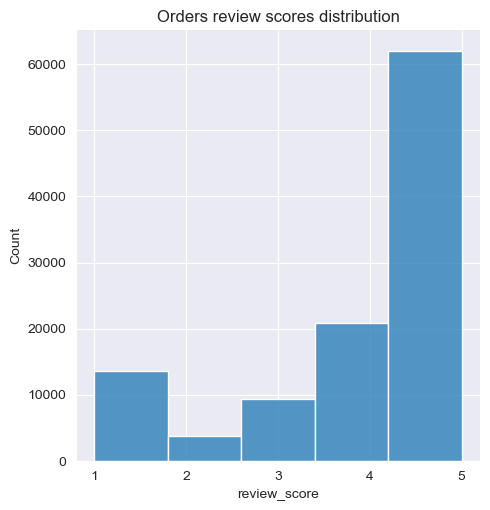

In [23]:
fig = sns.displot(data=db_full['review_score'], bins = 5)
fig.set(xticks=(1,2,3,4,5))
plt.title(f"Orders review scores distribution")
plt.show()

#### Price and delays relationship with review score

In [24]:
# Price and review score correlation
db_full[['price', 'review_score']].corr(method='spearman')

,price,review_score
price,1.00,0.01
review_score,0.01,1.00


In [25]:
db_full[['freight_value', 'review_score']].corr(method='spearman')

,freight_value,review_score
freight_value,1.00,-0.04
review_score,-0.04,1.00


In [26]:
# Delays and review score correlation
db_full['How_late?'] = pd.to_numeric(db_full['How_late?'])
db_full[['How_late?', 'review_score']].corr(method='spearman')

,How_late?,review_score
How_late?,1.00,-0.10
review_score,-0.10,1.00


We don't witness any relationship between price and review score, but the more the order arrives late, the more it negatively affects the score.

Now that we have explored a bit our dataset, we are gonna perform a first classification exercice with the use of an RFM score, well know technique in marketing analysis.

### RFM (segmentation)

Let's have a first and standard classification with an RFM score.

In [27]:
from datetime import datetime

#### Recency

In [28]:
db_full[['order_purchase_timestamp',
         'order_approved_at', 
         'order_delivered_carrier_date', 
         'order_delivered_customer_date',  
         'order_estimated_delivery_date',
         'shipping_limit_date']] = pd.to_datetime(db_full[['order_purchase_timestamp',
                                                           'order_approved_at', 
                                                           'order_delivered_carrier_date', 
                                                           'order_delivered_customer_date',  
                                                           'order_estimated_delivery_date',
                                                           'shipping_limit_date']].stack(), 
                                                  infer_datetime_format= True).unstack()


C:\Users\Gregoire\AppData\Local\Temp\ipykernel_20372\4018267605.py:6: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  'shipping_limit_date']] = pd.to_datetime(db_full[['order_purchase_timestamp',


In [29]:
db_full.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
payment_sequential                        int64
payment_type                             object
payment_installments                      int64
payment_value                           float64
review_id                                object
review_score                              int64
review_comment_title                     object
review_comment_message                   object
review_creation_date                    

In [30]:
recency_db = db_full.groupby(by='customer_unique_id',
                        as_index=False)['order_purchase_timestamp'].max()

recent_date = recency_db['order_purchase_timestamp'].max()

recency_db['Recency'] = recency_db['order_purchase_timestamp'].apply(
    lambda x: (recent_date - x).days)
recency_db.head()

,customer_unique_id,order_purchase_timestamp,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,115
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,118
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,541
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,325
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,292


We now have a number of days since the last order date of a given customer, which gives us the Recency criterion.

#### Frequency

In [31]:
frequency_db = db_full.drop_duplicates().groupby(
    by=['customer_unique_id'], as_index=False)['order_purchase_timestamp'].count()
frequency_db.columns = ['customer_unique_id', 'Frequency']
frequency_db.sort_values(by='Frequency', ascending = False)

,customer_unique_id,Frequency
53444,9a736b248f67d166d2fbb006bcb877c3,75
38705,6fbc7cdadbb522125f4b27ae9dee4060,38
86357,f9ae226291893fda10af7965268fb7f6,35
30039,569aa12b73b5f7edeaa6f2a01603e381,26
10152,1d2435aa3b858d45c707c9fc25e18779,24
...,...,...
31824,5b9f3a22a2f637041e498817b1e956cd,1
31823,5b9e2d80a7ebfcf10ed0fa934a6de8f9,1
31822,5b9ded8428365feb7e1eac3fc3085132,1
31821,5b9dadf41a68e39b12686c14eec1eb36,1


Our most regular customer has ordered 75 times, while the second and third respectively have 38 and 35 orders.
We now have the Frequency criterion.

#### Monetary value

In [32]:
# What monetary variable to take into account
db_full[['payment_value', 'price', 'freight_value']]

# we decide to exclude the shipping price, even if it can be a criterion accounted for when a customer pass an order.

,payment_value,price,freight_value
0,146.87,124.99,21.88
1,335.48,289.00,46.48
2,157.73,139.94,17.79
3,173.30,149.94,23.36
4,252.25,230.00,22.25
...,...,...,...
115603,75.88,55.00,20.88
115604,88.78,74.90,13.88
115605,129.06,114.90,14.16
115606,56.04,37.00,19.04


In [33]:
monetary_db = db_full.groupby(by='customer_unique_id', as_index=False)['price'].sum()
monetary_db.columns = ['customer_unique_id', 'Monetary']
monetary_db.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


#### Combining the three criteria

In [34]:
#### Combining the three criteria in a single dataframe
rf_db = recency_db.merge(frequency_db, on='customer_unique_id')
rfm_db = rf_db.merge(monetary_db, on='customer_unique_id').drop(
    columns='order_purchase_timestamp')
rfm_db.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
2,0000f46a3911fa3c0805444483337064,541,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00


We now have a ranking of the customers, on a 0 to 5 scale, for each criterion. 
Next step is to represent the distributions, create the bins in each criterion, and assign a label to each customer.

### RFM scores distributions

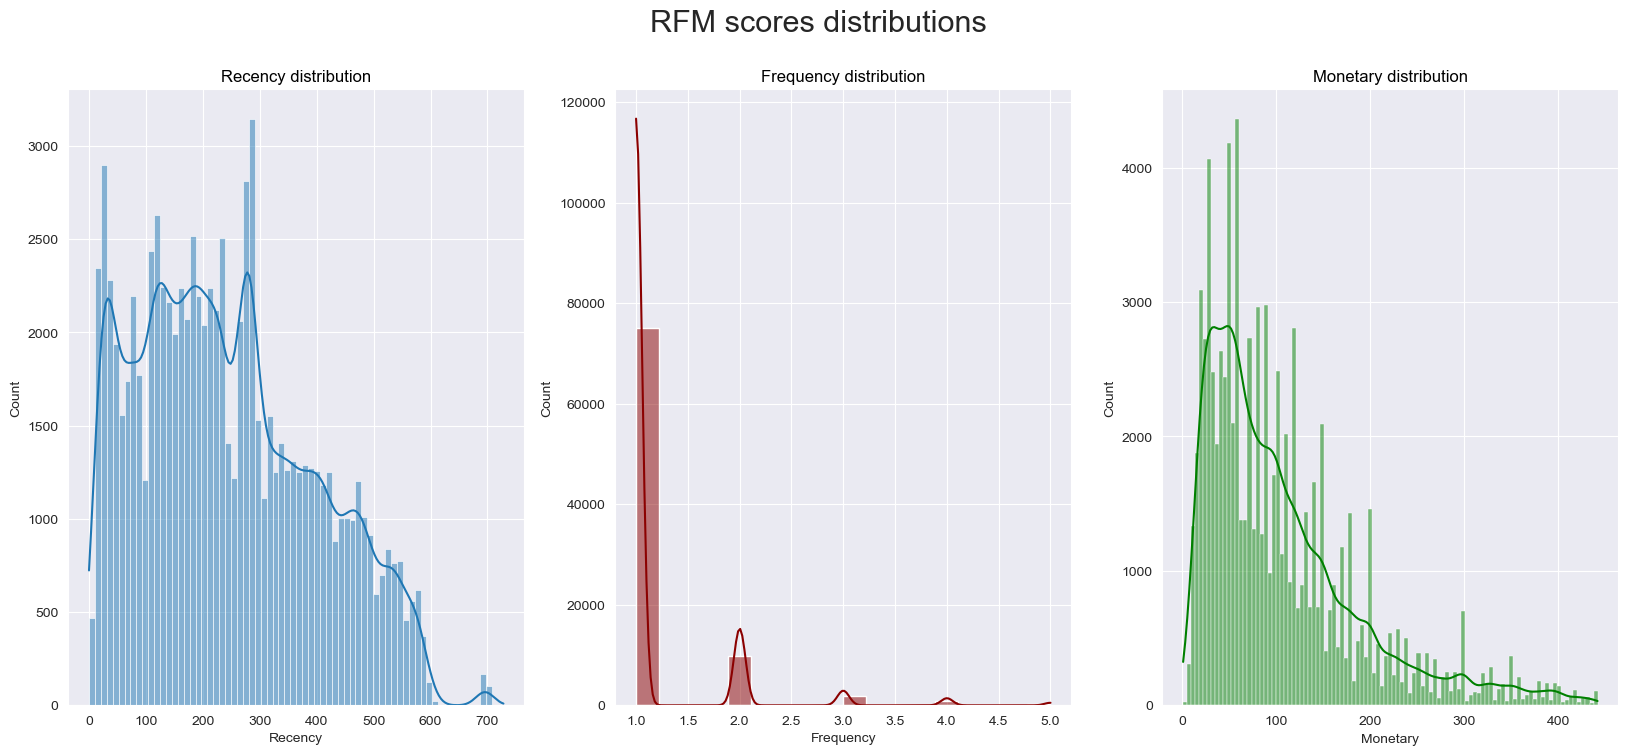

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(20,8))

sns.histplot(data=rfm_db, x='Recency', kde=True, ax=axes[0], alpha=0.5)
axes[0].set_title("Recency distribution", color='black')

sns.histplot(data = rfm_db[rfm_db['Frequency'] <= 5], x='Frequency', kde=True, ax=axes[1], color="darkred", alpha=0.5)
axes[1].set_title("Frequency distribution", color='black')

sns.histplot(data = rfm_db[rfm_db['Monetary'] < (rfm_db['Monetary'].mean()+2.5*(rfm_db['Monetary'].std()))], x='Monetary', kde=True, ax=axes[2], color="green", alpha=0.5)
axes[2].set_title("Monetary distribution", color='black')

plt.suptitle("RFM scores distributions", fontsize=22)
plt.show()

The three distributions are heavily left-biaised. Regarding the first one, it's interesting to note that most customers have bought this last year as most of them are under 400 days.
The second distribution show that customers do not transact a lot with Olist's sellers, and that it's more a "one-time" purchase.
Last, the third graph displays maybe the less unexpected distribution, with a highly significant and negative relationship between the number of orders and the monetray value of each order: people tend to buy less expensive objects on the internet. It could be verified with an analysis of the product categories.

Let's now compute the rank of each customer in each category, on a 0 to 5 scale, and sum the three to create a final ranking.

### RFM total score and rankings

In [36]:
rfm_db['R_rank'] = rfm_db['Recency'].rank(ascending=False)
rfm_db['F_rank'] = rfm_db['Frequency'].rank(ascending=True)
rfm_db['M_rank'] = rfm_db['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers, on a '5 stars' scale for each criterion
rfm_db['R_rank_norm'] = (rfm_db['R_rank']/rfm_db['R_rank'].max())*5
rfm_db['F_rank_norm'] = (rfm_db['F_rank']/rfm_db['F_rank'].max())*5
rfm_db['M_rank_norm'] = (rfm_db['M_rank']/rfm_db['M_rank'].max())*5
rfm_db['RFM_score'] = rfm_db['R_rank_norm'] + rfm_db['F_rank_norm'] + rfm_db['M_rank_norm']

rfm_db.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_db.head()

,customer_unique_id,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,115,1,129.90,3.82,2.12,3.48,9.42
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,3.76,2.12,0.22,6.11
2,0000f46a3911fa3c0805444483337064,541,1,69.00,0.18,2.12,2.04,4.34
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,1.44,2.12,0.52,4.08
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,1.69,2.12,4.14,7.95


Every customer has now a score in each criterion, and a total score. We are now going to give each of them a label, corresponding to their total score.

In [37]:
rfm_db['Customer_segment'] = np.where(rfm_db['RFM_score'] >=
                                      12, "Top Customers",
                                      (np.where(
                                        rfm_db['RFM_score'] >= 9,
                                        "High value Customer",
                                        (np.where(rfm_db['RFM_score'] >= 6,
                             "Medium Value Customer",
                             np.where(rfm_db['RFM_score'] >= 3,
                            'Low Value Customers', 'Worst Customers'))))))
rfm_db[['customer_unique_id', 'RFM_score', 'Customer_segment']].head(10)

,customer_unique_id,RFM_score,Customer_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,9.42,High value Customer
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6.11,Medium Value Customer
2,0000f46a3911fa3c0805444483337064,4.34,Low Value Customers
3,0000f6ccb0745a6a4b88665a16c9f078,4.08,Low Value Customers
4,0004aac84e0df4da2b147fca70cf8255,7.95,Medium Value Customer
5,0004bd2a26a76fe21f786e4fbd80607f,9.35,High value Customer
6,00050ab1314c0e55a6ca13cf7181fecf,6.25,Medium Value Customer
7,00053a61a98854899e70ed204dd4bafe,12.29,Top Customers
8,0005e1862207bf6ccc02e4228effd9a0,5.84,Low Value Customers
9,0005ef4cd20d2893f0d9fbd94d3c0d97,8.22,Medium Value Customer


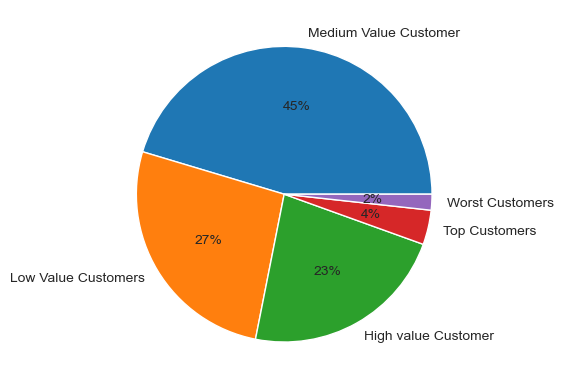

In [38]:
plt.pie(rfm_db.Customer_segment.value_counts(),
        labels=rfm_db.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

To perform this ranking, we have given each criterion the wame weight, meaning that we equally value recency, frequency and monetary (we have simply aggregated the three scores). Of course this can be modified according to Olist preferencies.

In the next notebook, we are going to perform another client segmentation, using a clustering technique.

In [39]:
# CSV exports
db_full.to_csv('Data/olist_db_full.csv', index = False)
rfm_db.to_csv('Data/olist_rfm_db.csv', index = False)